In [1]:
import pandas as pd
df = pd.read_csv("../Data/aggregated_spice_price_data_2019_2024.csv")
df

,Price Date,Min Price (Rs./Quintal),Max Price (Rs./Quintal),Modal Price (Rs./Quintal)
0,2019-10-31,8476.100000,9156.250000,8854.900000
1,2019-11-01,8362.619048,10080.666667,9385.238095
2,2019-11-02,8228.023256,9744.162791,9147.720930
3,2019-11-03,8620.000000,8881.111111,8768.888889
4,2019-11-04,8185.625000,9976.950000,9199.375000
...,...,...,...,...
1822,2024-10-26,9873.513514,11910.000000,11096.297297
1823,2024-10-27,10366.666667,10916.666667,10635.166667
1824,2024-10-28,10333.593750,11987.500000,11361.281250
1825,2024-10-29,9893.684211,11420.263158,10820.263158


In [2]:
df = df[["Price Date", "Modal Price (Rs./Quintal)"]]
df.loc[:, 'Price Date'] = pd.to_datetime(df['Price Date'])
df.set_index('Price Date', inplace=True)
index_dtype = df.index.dtype
print(f"Datatype of the index: {index_dtype}")

Datatype of the index: datetime64[ns]


/Users/tejas/PycharmProjects/Spice_Price_Forecast/.venv/lib/python3.12/site-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


In [3]:
import seaborn as sns
color_pal = sns.color_palette()

<Axes: title={'center': 'Modal Price'}, xlabel='Price Date'>

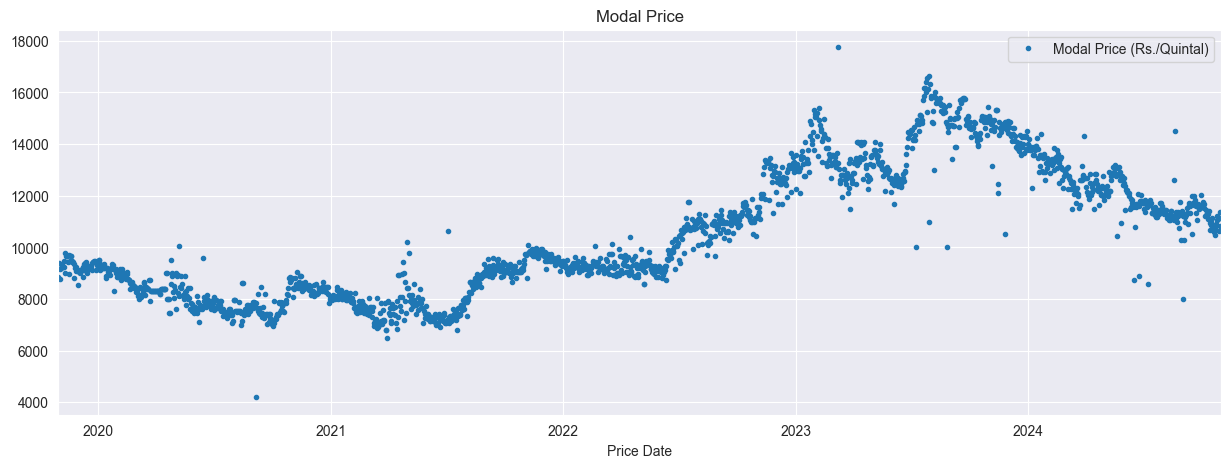

In [4]:
df.plot(style='.', figsize=(15, 5), color=color_pal[0], title="Modal Price", )

In [5]:
train_df = df.iloc[df.index<'01-01-2024']
test_df = df.iloc[df.index>='01-01-2024']

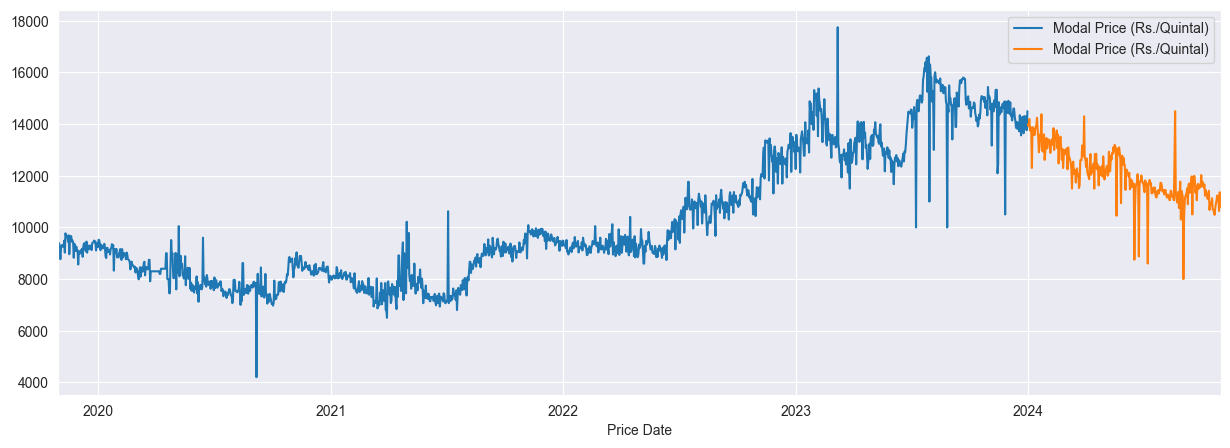

In [6]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 5))
train_df.plot(ax=ax, label='Training set')
test_df.plot(ax=ax, label='Test set')
plt.show()


<Axes: xlabel='Price Date'>

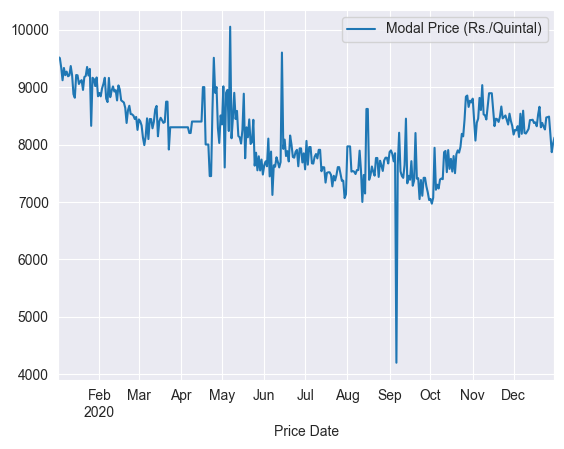

In [7]:
df.iloc[(df.index>'01-01-2020') & (df.index<'01-01-2021')].plot()

<Axes: xlabel='Price Date'>

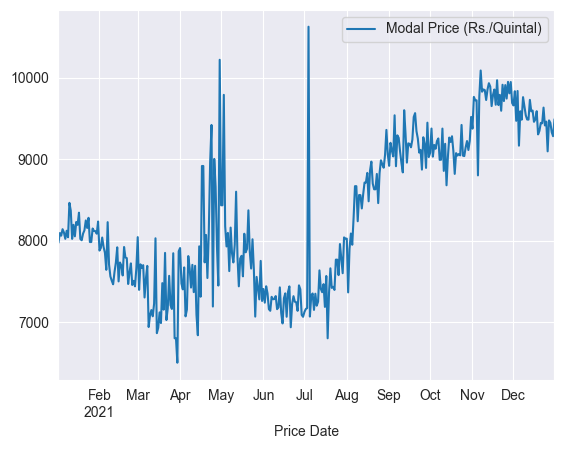

In [8]:
df.iloc[(df.index>'01-01-2021') & (df.index<'01-01-2022')].plot()

<Axes: xlabel='Price Date'>

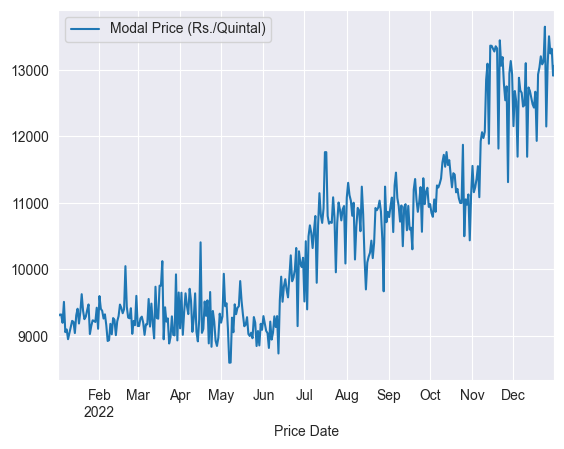

In [9]:
df.iloc[(df.index>'01-01-2022') & (df.index<'01-01-2023')].plot()

<Axes: xlabel='Price Date'>

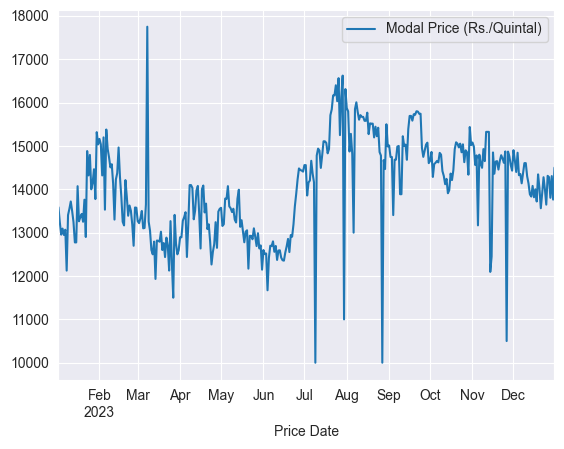

In [10]:
df.iloc[(df.index>'01-01-2023') & (df.index<'01-01-2024')].plot()

In [11]:
import pandas as pd

target_map = df['Modal Price (Rs./Quintal)'].to_dict()

def create_features(df):
    """
    Create time series features based on time series index for weekly forecasting.
    """
    df = df.copy()

    # Time-based features
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['weekofyear'] = df.index.isocalendar().week

    # Lag features
    df['lag7'] = (df.index - pd.Timedelta('7 days')).map(target_map)
    df['lag14'] = (df.index - pd.Timedelta('14 days')).map(target_map)
    df['lag21'] = (df.index - pd.Timedelta('21 days')).map(target_map)
    df['lag28'] = (df.index - pd.Timedelta('28 days')).map(target_map)

    # Rolling window features
    for window in [7, 14, 21, 28]:
        df[f'rolling_mean_{window}'] = df['Modal Price (Rs./Quintal)'].rolling(window=window, min_periods=1).mean()
        df[f'rolling_median_{window}'] = df['Modal Price (Rs./Quintal)'].rolling(window=window, min_periods=1).median()
        df[f'rolling_std_{window}'] = df['Modal Price (Rs./Quintal)'].rolling(window=window, min_periods=1).std()

    # Exponential moving averages
    df['ema7'] = df['Modal Price (Rs./Quintal)'].ewm(span=7, adjust=False).mean()
    df['ema14'] = df['Modal Price (Rs./Quintal)'].ewm(span=14, adjust=False).mean()

    # Moving averages
    df['moving_avg_7'] = df['Modal Price (Rs./Quintal)'].rolling(window=7, min_periods=1).mean()
    df['moving_avg_14'] = df['Modal Price (Rs./Quintal)'].rolling(window=14, min_periods=1).mean()

    # Other statistical features
    df['max_28'] = df['Modal Price (Rs./Quintal)'].rolling(window=28, min_periods=1).max()
    df['min_28'] = df['Modal Price (Rs./Quintal)'].rolling(window=28, min_periods=1).min()
    df['range_28'] = df['max_28'] - df['min_28']

    return df


In [12]:
df = create_features(df)
df

,Modal Price (Rs./Quintal),dayofweek,quarter,month,year,dayofyear,weekofyear,lag7,lag14,lag21,...,rolling_mean_28,rolling_median_28,rolling_std_28,ema7,ema14,moving_avg_7,moving_avg_14,max_28,min_28,range_28
Price Date,,,,,,,,,,,,,,,,,,,,,
2019-10-31,8854.900000,3,4,10,2019,304,44,NaN,NaN,NaN,...,8854.900000,8854.900000,NaN,8854.900000,8854.900000,8854.900000,8854.900000,8854.900000,8854.900000,0.000000
2019-11-01,9385.238095,4,4,11,2019,305,44,NaN,NaN,NaN,...,9120.069048,9120.069048,375.005663,8987.484524,8925.611746,9120.069048,9120.069048,9385.238095,8854.900000,530.338095
2019-11-02,9147.720930,5,4,11,2019,306,44,NaN,NaN,NaN,...,9129.286342,9147.720930,265.649204,9027.543625,8955.226304,9129.286342,9129.286342,9385.238095,8854.900000,530.338095
2019-11-03,8768.888889,6,4,11,2019,307,44,NaN,NaN,NaN,...,9039.186979,9001.310465,281.989209,8962.879941,8930.381315,9039.186979,9039.186979,9385.238095,8768.888889,616.349206
2019-11-04,9199.375000,0,4,11,2019,308,45,NaN,NaN,NaN,...,9071.224583,9147.720930,254.500444,9022.003706,8966.247140,9071.224583,9071.224583,9385.238095,8768.888889,616.349206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-26,11096.297297,5,4,10,2024,300,43,10592.647059,10675.000000,11223.750000,...,11162.304372,11145.820968,388.514015,11023.105896,11002.904952,10954.783015,10896.042643,12025.500000,10485.714286,1539.785714
2024-10-27,10635.166667,6,4,10,2024,301,43,10485.714286,10933.333333,11450.000000,...,11112.649610,11116.929791,362.051540,10926.121089,10953.873181,10976.133355,10874.745024,11766.900000,10485.714286,1281.185714
2024-10-28,11361.281250,0,4,10,2024,302,44,10748.242424,10973.571429,11271.484848,...,11104.225831,11116.929791,352.991900,11034.911129,11008.194257,11063.710330,10902.438583,11766.900000,10485.714286,1281.185714


In [13]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

# Custom metrics
def smape(y_true, y_pred):
    """Symmetric Mean Absolute Percentage Error"""
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

def mdape(y_true, y_pred):
    """Median Absolute Percentage Error"""
    return 100 * np.median(np.abs((y_pred - y_true) / y_true))

def gmrae(y_true, y_pred):
    """Geometric Mean Relative Absolute Error"""
    numerator = np.abs(y_true - y_pred)
    denominator = np.abs(y_true - np.mean(y_true))
    ratio = numerator / denominator
    return np.exp(np.mean(np.log(ratio + 1e-10)))

# Define target and features
y = df['Modal Price (Rs./Quintal)']
feature_columns = [col for col in df.columns if col != 'Modal Price (Rs./Quintal)']
X = df[feature_columns]

# Define the base XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Split into 5 sets, each of 30 days
n_splits = 5
test_days = 30

# Calculate total number of splits and test range
total_days = len(y)
split_size = total_days // n_splits

metrics_per_split = []

# Time-based split
for i in range(n_splits):
    # Define train and test indices
    train_end = split_size * (i + 1) - test_days
    test_start = train_end
    test_end = split_size * (i + 1)

    X_train, X_test = X.iloc[:train_end], X.iloc[test_start:test_end]
    y_train, y_test = y.iloc[:train_end], y.iloc[test_start:test_end]

    # Train the model
    xgb_model.fit(X_train, y_train)

    # Predict
    y_pred = xgb_model.predict(X_test)

    # Calculate metrics
    rmse = np.sqrt(mean_absolute_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    smape_val = smape(y_test, y_pred)
    mdape_val = mdape(y_test, y_pred)
    gmrae_val = gmrae(y_test, y_pred)

    metrics_per_split.append({
        'Split': i + 1,
        'RMSE': rmse,
        'MAE': mae,
        'SMAPE': smape_val,
        'MDAPE': mdape_val,
        'GMRAE': gmrae_val
    })

# Print metrics for each split
for metrics in metrics_per_split:
    print(f"Split {metrics['Split']}:")
    for metric_name, metric_value in metrics.items():
        if metric_name != 'Split':
            print(f"  {metric_name}: {metric_value:.4f}")


Split 1:
  RMSE: 23.8758
  MAE: 570.0521
  SMAPE: 8.1807
  MDAPE: 3.6030
  GMRAE: 0.8168
Split 2:
  RMSE: 10.8382
  MAE: 117.4668
  SMAPE: 1.2920
  MDAPE: 1.0746
  GMRAE: 0.8627
Split 3:
  RMSE: 19.0515
  MAE: 362.9613
  SMAPE: 3.2466
  MDAPE: 2.5361
  GMRAE: 1.5566
Split 4:
  RMSE: 17.8415
  MAE: 318.3179
  SMAPE: 2.2153
  MDAPE: 1.7955
  GMRAE: 1.1337
Split 5:
  RMSE: 15.1646
  MAE: 229.9652
  SMAPE: 2.0933
  MDAPE: 1.1334
  GMRAE: 0.5081


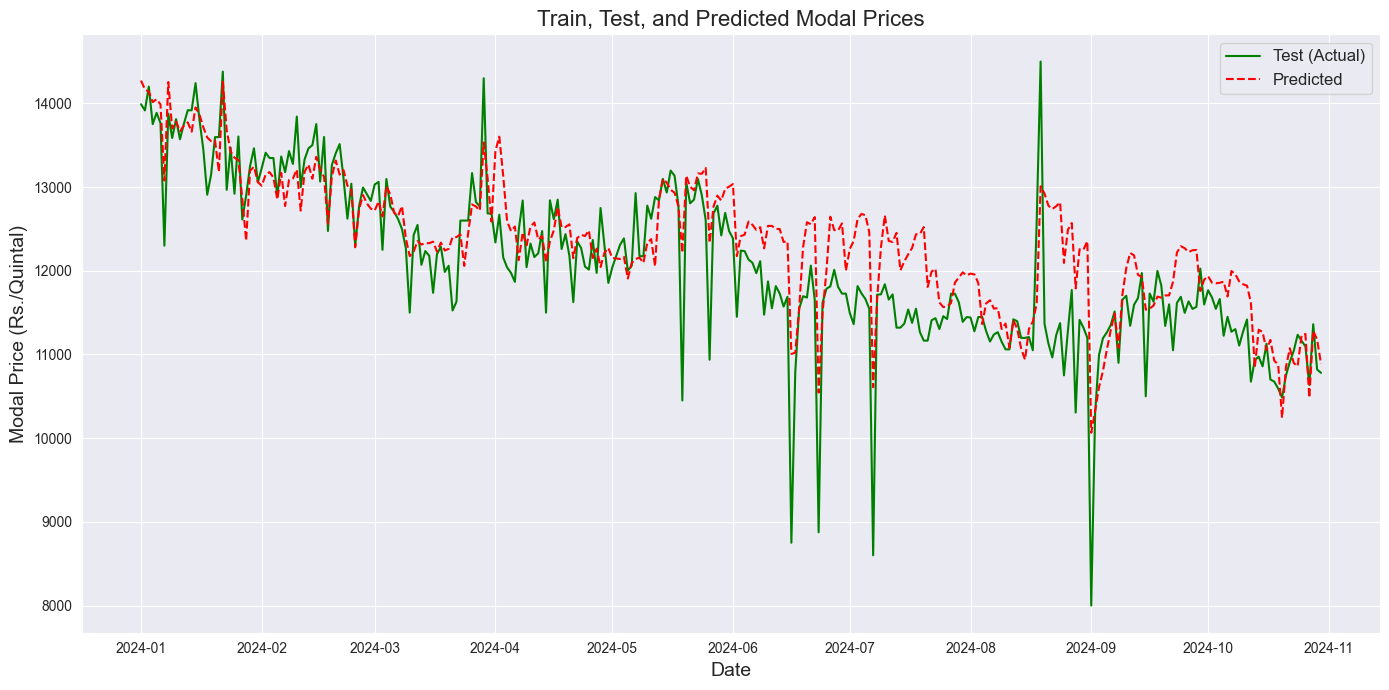

Metrics:
Mean Absolute Error (MAE): 430.1853
Symmetric Mean Absolute Percentage Error (SMAPE): 3.6137
Median Absolute Percentage Error (MDAPE): 2.5459
Geometric Mean Relative Absolute Error (GMRAE): 0.4564


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

# Assuming `df` contains your data, and it is already prepared with features and target column
# Define train and test data
train_data = df.loc[:'2023-12-31']
test_data = df.loc['2024-01-01':'2024-10-31']

# Extract features and target
feature_columns = [col for col in df.columns if col != 'Modal Price (Rs./Quintal)']
X_train = train_data[feature_columns]
y_train = train_data['Modal Price (Rs./Quintal)']
X_test = test_data[feature_columns]
y_test = test_data['Modal Price (Rs./Quintal)']
model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Add predictions to test data
test_data = test_data.copy()  # Avoid SettingWithCopyWarning
test_data['Predicted'] = y_pred

# Plot
plt.figure(figsize=(14, 7))


# Plot test data (actual values)
plt.plot(test_data.index, test_data['Modal Price (Rs./Quintal)'], label='Test (Actual)', color='green')

# Plot predictions
plt.plot(test_data.index, test_data['Predicted'], label='Predicted', color='red', linestyle='--')

# Add title and labels
plt.title("Train, Test, and Predicted Modal Prices", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Modal Price (Rs./Quintal)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()

# Metrics Calculation
def smape(y_true, y_pred):
    """Symmetric Mean Absolute Percentage Error"""
    non_zero_mask = (np.abs(y_true) + np.abs(y_pred)) > 0  # Avoid division by zero
    return 100 * np.mean(2 * np.abs(y_pred[non_zero_mask] - y_true[non_zero_mask]) /
                         (np.abs(y_true[non_zero_mask]) + np.abs(y_pred[non_zero_mask])))

def mdape(y_true, y_pred):
    """Median Absolute Percentage Error"""
    non_zero_mask = y_true != 0  # Avoid division by zero
    return 100 * np.median(np.abs((y_pred[non_zero_mask] - y_true[non_zero_mask]) / y_true[non_zero_mask]))

def gmrae(y_true, y_pred):
    """Geometric Mean Relative Absolute Error"""
    numerator = np.abs(y_true - y_pred)
    denominator = np.abs(y_true - np.mean(y_true))
    ratio = numerator / (denominator + 1e-10)  # Avoid division by zero
    return np.exp(np.mean(np.log(ratio + 1e-10)))

mae = mean_absolute_error(y_test, y_pred)
smape_val = smape(y_test.values, y_pred)
mdape_val = mdape(y_test.values, y_pred)
gmrae_val = gmrae(y_test.values, y_pred)

# Print metrics
print("Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Symmetric Mean Absolute Percentage Error (SMAPE): {smape_val:.4f}")
print(f"Median Absolute Percentage Error (MDAPE): {mdape_val:.4f}")
print(f"Geometric Mean Relative Absolute Error (GMRAE): {gmrae_val:.4f}")


In [15]:
import pandas as pd
import numpy as np
from itertools import product
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

# Assuming X_train, y_train, X_test, and y_test are defined
# Define the hyperparameter grid
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 150],
    'booster': ['gbtree', 'dart']
}

# Generate all combinations of hyperparameters
param_combinations = list(product(
    param_grid['learning_rate'],
    param_grid['max_depth'],
    param_grid['n_estimators'],
    param_grid['booster']
))

# Store results for comparison
results = []

# Iterate through each parameter combination
for params in param_combinations:
    # Unpack parameters
    learning_rate, max_depth, n_estimators, booster = params

    # Define the model with the current parameters
    model = XGBRegressor(
        objective='reg:squarederror',
        learning_rate=learning_rate,
        max_depth=max_depth,
        n_estimators=n_estimators,
        booster=booster,
        random_state=42
    )

    # Train the model on the training data
    model.fit(X_train, y_train)

    # Predict on the test data
    y_pred = model.predict(X_test)

    # Evaluate performance using MAE
    mae = mean_absolute_error(y_test, y_pred)

    # Save the results
    results.append({
        'learning_rate': learning_rate,
        'max_depth': max_depth,
        'n_estimators': n_estimators,
        'booster': booster,
        'mae': mae
    })

    print(f"Evaluated params: {params} | MAE: {mae:.4f}")

# Convert results to a DataFrame for easy analysis
results_df = pd.DataFrame(results)

# Find the best parameters (lowest MAE)
best_params = results_df.loc[results_df['mae'].idxmin()]

# Print the best parameters and corresponding score
print("\nBest Parameters:")
print(best_params)

# Train the final model with the best parameters
final_model = XGBRegressor(
    objective='reg:squarederror',
    learning_rate=best_params['learning_rate'],
    max_depth=int(best_params['max_depth']),
    n_estimators=int(best_params['n_estimators']),
    booster=best_params['booster'],
    random_state=42
)

final_model.fit(X_train, y_train)
y_pred_final = final_model.predict(X_test)

# Calculate metrics for the final model
final_mae = mean_absolute_error(y_test, y_pred_final)
print(f"\nFinal Model MAE: {final_mae:.4f}")

# Output the final predictions for visualization or further analysis
print("\nFinal Predictions:")
print(pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred_final}, index=y_test.index).head())


Evaluated params: (0.01, 3, 50, 'gbtree') | MAE: 1147.2667
Evaluated params: (0.01, 3, 50, 'dart') | MAE: 1147.2667
Evaluated params: (0.01, 3, 100, 'gbtree') | MAE: 653.3733
Evaluated params: (0.01, 3, 100, 'dart') | MAE: 653.3732
Evaluated params: (0.01, 3, 150, 'gbtree') | MAE: 454.8697
Evaluated params: (0.01, 3, 150, 'dart') | MAE: 454.8696
Evaluated params: (0.01, 5, 50, 'gbtree') | MAE: 1159.4315
Evaluated params: (0.01, 5, 50, 'dart') | MAE: 1159.4315
Evaluated params: (0.01, 5, 100, 'gbtree') | MAE: 694.0855
Evaluated params: (0.01, 5, 100, 'dart') | MAE: 694.0855
Evaluated params: (0.01, 5, 150, 'gbtree') | MAE: 466.4821
Evaluated params: (0.01, 5, 150, 'dart') | MAE: 466.4821
Evaluated params: (0.01, 7, 50, 'gbtree') | MAE: 1168.4810
Evaluated params: (0.01, 7, 50, 'dart') | MAE: 1168.4811
Evaluated params: (0.01, 7, 100, 'gbtree') | MAE: 717.8808
Evaluated params: (0.01, 7, 100, 'dart') | MAE: 717.8808
Evaluated params: (0.01, 7, 150, 'gbtree') | MAE: 485.7032
Evaluated par

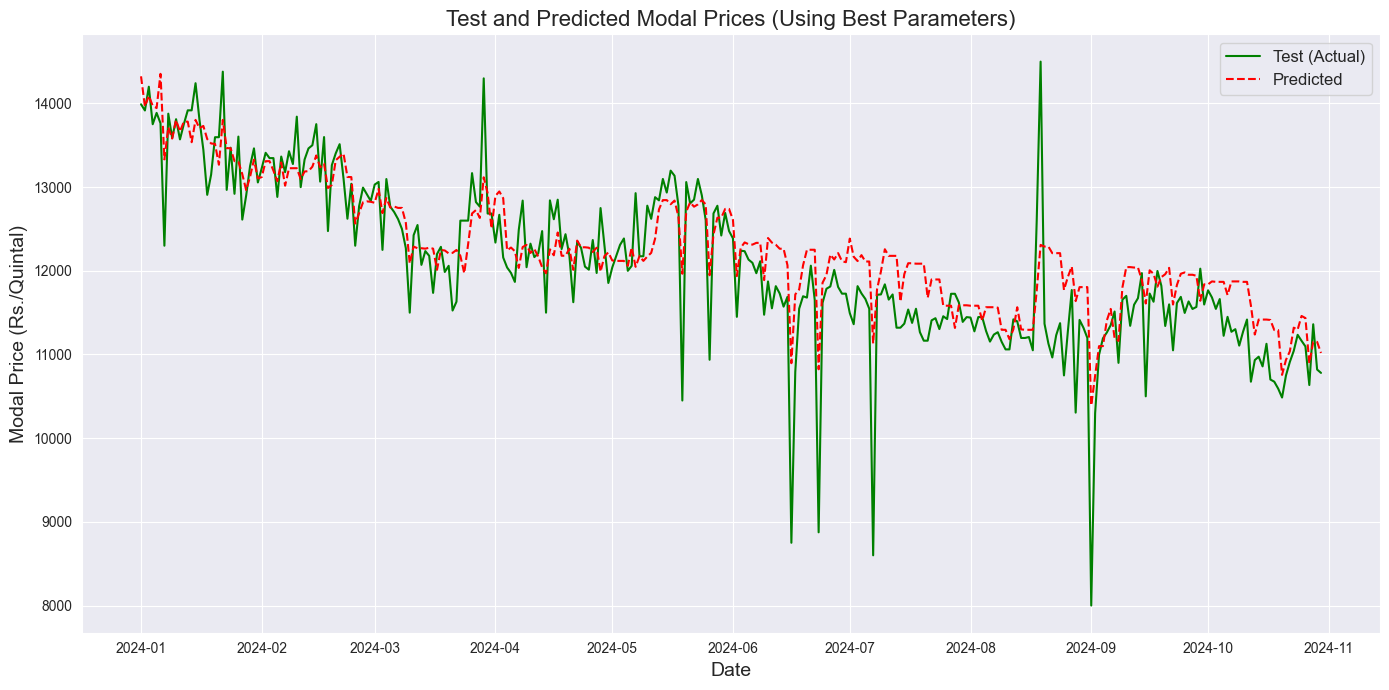

Metrics:
Mean Absolute Error (MAE): 371.2147
Symmetric Mean Absolute Percentage Error (SMAPE): 3.1466
Median Absolute Percentage Error (MDAPE): 2.3477
Geometric Mean Relative Absolute Error (GMRAE): 0.4353


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

# Assuming `df` contains your data, and it is already prepared with features and target column
# Define train and test data
train_data = df.loc[:'2023-12-31']
test_data = df.loc['2024-01-01':'2024-10-31']

# Extract features and target
feature_columns = [col for col in df.columns if col != 'Modal Price (Rs./Quintal)']
X_train = train_data[feature_columns]
y_train = train_data['Modal Price (Rs./Quintal)']
X_test = test_data[feature_columns]
y_test = test_data['Modal Price (Rs./Quintal)']

# Best parameters from hyperparameter tuning
best_params = {
    'booster': 'dart',
    'learning_rate': 0.2,
    'max_depth': 3,
    'n_estimators': 50,
    'objective': 'reg:squarederror',
    'random_state': 42
}

# Initialize the model with the best parameters
model = XGBRegressor(**best_params)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Add predictions to test data
test_data = test_data.copy()  # Avoid SettingWithCopyWarning
test_data['Predicted'] = y_pred

# Plot
plt.figure(figsize=(14, 7))

# Plot test data (actual values)
plt.plot(test_data.index, test_data['Modal Price (Rs./Quintal)'], label='Test (Actual)', color='green')

# Plot predictions
plt.plot(test_data.index, test_data['Predicted'], label='Predicted', color='red', linestyle='--')

# Add title and labels
plt.title("Test and Predicted Modal Prices (Using Best Parameters)", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Modal Price (Rs./Quintal)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()

# Metrics Calculation
def smape(y_true, y_pred):
    """Symmetric Mean Absolute Percentage Error"""
    non_zero_mask = (np.abs(y_true) + np.abs(y_pred)) > 0  # Avoid division by zero
    return 100 * np.mean(2 * np.abs(y_pred[non_zero_mask] - y_true[non_zero_mask]) /
                         (np.abs(y_true[non_zero_mask]) + np.abs(y_pred[non_zero_mask])))

def mdape(y_true, y_pred):
    """Median Absolute Percentage Error"""
    non_zero_mask = y_true != 0  # Avoid division by zero
    return 100 * np.median(np.abs((y_pred[non_zero_mask] - y_true[non_zero_mask]) / y_true[non_zero_mask]))

def gmrae(y_true, y_pred):
    """Geometric Mean Relative Absolute Error"""
    numerator = np.abs(y_true - y_pred)
    denominator = np.abs(y_true - np.mean(y_true))
    ratio = numerator / (denominator + 1e-10)  # Avoid division by zero
    return np.exp(np.mean(np.log(ratio + 1e-10)))

mae = mean_absolute_error(y_test, y_pred)
smape_val = smape(y_test.values, y_pred)
mdape_val = mdape(y_test.values, y_pred)
gmrae_val = gmrae(y_test.values, y_pred)

# Print metrics
print("Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Symmetric Mean Absolute Percentage Error (SMAPE): {smape_val:.4f}")
print(f"Median Absolute Percentage Error (MDAPE): {mdape_val:.4f}")
print(f"Geometric Mean Relative Absolute Error (GMRAE): {gmrae_val:.4f}")


In [17]:
# Function to calculate metrics for each week
def calculate_weekly_metrics(test_data, y_test, y_pred):
    weekly_metrics = []

    # Group by week
    for week, week_data in test_data.groupby('Week'):
        # Get the integer positions of the indices using get_indexer
        positions = test_data.index.get_indexer(week_data.index)

        # Get actual and predicted values for the current week
        week_y_true = y_test.iloc[positions]  # Use iloc for integer-based indexing
        week_y_pred = y_pred[positions]  # Use integer-based indexing for numpy array

        # Calculate the metrics for this week
        mae_week = mean_absolute_error(week_y_true, week_y_pred)
        smape_week = smape(week_y_true.values, week_y_pred)
        mdape_week = mdape(week_y_true.values, week_y_pred)
        gmrae_week = gmrae(week_y_true.values, week_y_pred)

        # Store the metrics for the week
        weekly_metrics.append({
            'Week': week,
            'MAE': mae_week,
            'SMAPE': smape_week,
            'MDAPE': mdape_week,
            'GMRAE': gmrae_week
        })

    return pd.DataFrame(weekly_metrics)

# Calculate weekly metrics
weekly_metrics_df = calculate_weekly_metrics(test_data, y_test, y_pred)

# Print the weekly metrics
print("Week-wise Metrics:")
print(weekly_metrics_df)


KeyError: 'Week'

Sliding Window Metrics:
Mean Absolute Error (MAE): 372.3241
Symmetric Mean Absolute Percentage Error (SMAPE): 3.1545
Median Absolute Percentage Error (MDAPE): 2.3481
Geometric Mean Relative Absolute Error (GMRAE): 0.4346


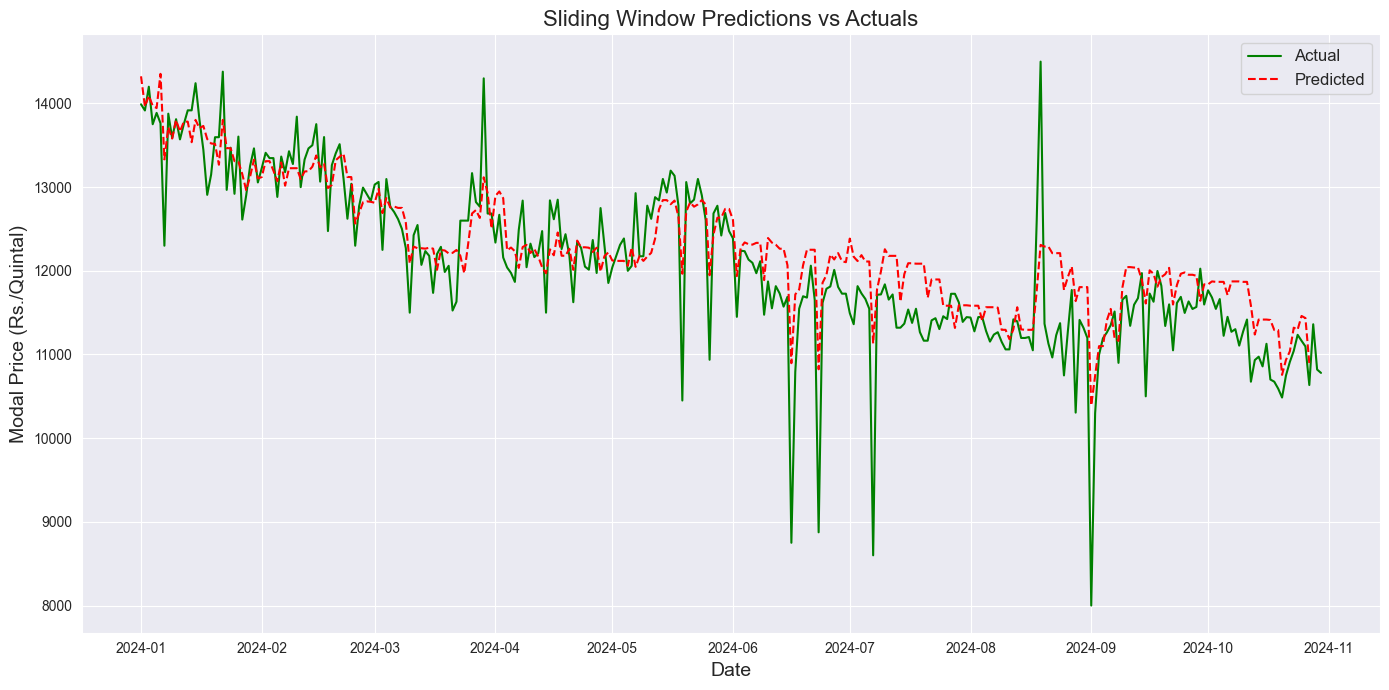

In [18]:
from datetime import timedelta

# Define the sliding window size (1 weeks)
window_size = 7  # Days

# Initialize results storage
all_predictions = []
all_actuals = []

# Start the sliding window process
current_start = test_data.index.min()
current_end = current_start + timedelta(days=window_size - 1)

while current_end <= test_data.index.max():
    # Extract the current window data
    current_window = test_data.loc[current_start:current_end]

    # Extract features and target for the current window
    X_current = current_window[feature_columns]
    y_actual = current_window['Modal Price (Rs./Quintal)']

    # Make predictions for the current window
    y_pred_current = model.predict(X_current)

    # Store predictions and actual values
    all_predictions.extend(y_pred_current)
    all_actuals.extend(y_actual.values)

    # Move the window forward
    current_start = current_end + timedelta(days=1)
    current_end = current_start + timedelta(days=window_size - 1)

# Calculate metrics for the entire test set based on sliding window predictions
mae = mean_absolute_error(all_actuals, all_predictions)
smape_val = smape(np.array(all_actuals), np.array(all_predictions))
mdape_val = mdape(np.array(all_actuals), np.array(all_predictions))
gmrae_val = gmrae(np.array(all_actuals), np.array(all_predictions))

# Print metrics
print("Sliding Window Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Symmetric Mean Absolute Percentage Error (SMAPE): {smape_val:.4f}")
print(f"Median Absolute Percentage Error (MDAPE): {mdape_val:.4f}")
print(f"Geometric Mean Relative Absolute Error (GMRAE): {gmrae_val:.4f}")

# Plot the predictions vs actual values
plt.figure(figsize=(14, 7))
plt.plot(test_data.index, test_data['Modal Price (Rs./Quintal)'], label='Actual', color='green')
plt.plot(test_data.index[:len(all_predictions)], all_predictions, label='Predicted', color='red', linestyle='--')
plt.title("Sliding Window Predictions vs Actuals", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Modal Price (Rs./Quintal)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


In [62]:
df_2024 = pd.read_csv("../VolumeData/spice_price_data_2024.csv")

In [63]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error  # Import the necessary function
df = create_features(df)
df_vis = df.copy()
df = df.iloc[df.index<'2024-10-31']
TARGET = 'Modal Price (Rs./Quintal)'
X_all = df.drop(columns=[TARGET])
y_all = df[TARGET]
reg = xgb.XGBRegressor(**best_params)

reg.fit(X_all, y_all, eval_set=[(X_all, y_all), (X_all, y_all)],verbose=100)

[0]	validation_0-rmse:1980.43348	validation_1-rmse:1980.43348
[49]	validation_0-rmse:250.86681	validation_1-rmse:250.86681


XGBRegressor(base_score=None, booster='dart', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [64]:
df_2024 = pd.read_csv("../VolumeData/spice_price_data_2024.csv")
df_2024 = df_2024[df_2024["Variety"]=="White"]

In [65]:
# Rename the column
df_2024 = df_2024.rename(columns={"Reported Date": "Price Date"})

# Verify the changes
print(df_2024.head())


        State Name  District Name           Market Name Variety      Group  \
1          Gujarat         Amreli                Rajula   White  Oil Seeds   
3          Gujarat     Banaskanth                 Deesa   White  Oil Seeds   
9          Gujarat      Bhavnagar  Mahuva(Station Road)   White  Oil Seeds   
17         Gujarat  Surendranagar           Dhragradhra   White  Oil Seeds   
23  Madhya Pradesh          Panna              Ajaygarh   White  Oil Seeds   

   Arrivals (Tonnes) Min Price (Rs./Quintal) Max Price (Rs./Quintal)  \
1               0.60                   12875                   12875   
3               3.30                   10805                   12505   
9               2.30                    6500                   13050   
17              1.40                    9500                   11005   
23              6.10                   10400                   10600   

   Modal Price (Rs./Quintal)   Price Date  
1                      12875  06 Nov 2024  
3         

In [66]:
# Convert 'Price Date' column to datetime, with invalid parsing entries turned into NaT
df_2024["Price Date"] = pd.to_datetime(df_2024["Price Date"], errors="coerce")

# Drop rows where 'Price Date' is NaT after conversion (if needed)
df_2024 = df_2024.dropna(subset=["Price Date"])

# Set 'Price Date' as the index
df_2024.set_index('Price Date', inplace=True)

# Verify the index dtype
index_dtype = df_2024.index.dtype
print(f"Datatype of the index: {index_dtype}")

# Check the resulting DataFrame
print(df_2024.head())


Datatype of the index: datetime64[ns]
                State Name  District Name           Market Name Variety  \
Price Date                                                                
2024-11-06         Gujarat         Amreli                Rajula   White   
2024-11-12         Gujarat     Banaskanth                 Deesa   White   
2024-11-07         Gujarat      Bhavnagar  Mahuva(Station Road)   White   
2024-11-06         Gujarat  Surendranagar           Dhragradhra   White   
2024-11-11  Madhya Pradesh          Panna              Ajaygarh   White   

                Group Arrivals (Tonnes) Min Price (Rs./Quintal)  \
Price Date                                                        
2024-11-06  Oil Seeds              0.60                   12875   
2024-11-12  Oil Seeds              3.30                   10805   
2024-11-07  Oil Seeds              2.30                    6500   
2024-11-06  Oil Seeds              1.40                    9500   
2024-11-11  Oil Seeds             

In [67]:
# Sort df_2024 by 'Price Date' (index)
df_2024 = df_2024.sort_index(ascending=True)
df_2024

,State Name,District Name,Market Name,Variety,Group,Arrivals (Tonnes),Min Price (Rs./Quintal),Max Price (Rs./Quintal),Modal Price (Rs./Quintal)
Price Date,,,,,,,,,
2024-11-02,Karnataka,Bidar,Basava Kalayana,White,Oil Seeds,2.00,7100,9700,8501
2024-11-02,Madhya Pradesh,Gwalior,Lashkar,White,Oil Seeds,3.00,12915,12915,12915
2024-11-03,Uttar Pradesh,Banda,Banda,White,Oil Seeds,40.00,10700,10950,10851
2024-11-03,Madhya Pradesh,Chhatarpur,LavKush Nagar(Laundi),White,Oil Seeds,17.20,9990,11000,11000
2024-11-03,Uttar Pradesh,Jalaun (Orai),Jalaun,White,Oil Seeds,16.00,10800,11500,11251
...,...,...,...,...,...,...,...,...,...
2024-11-13,Gujarat,Surendranagar,Dhragradhra,White,Oil Seeds,0.30,10570,10570,10570
2024-11-13,Gujarat,Amreli,Savarkundla,White,Oil Seeds,5.00,10500,13000,11750
2024-11-13,Gujarat,Amreli,Babra,White,Oil Seeds,0.80,10350,11750,11050


In [28]:
# Convert 'Modal Price (Rs./Quintal)' to float
df_2024['Modal Price (Rs./Quintal)'] = df_2024['Modal Price (Rs./Quintal)'].astype(float)

# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df_2024['Modal Price (Rs./Quintal)'].quantile(0.25)
Q3 = df_2024['Modal Price (Rs./Quintal)'].quantile(0.75)

# Calculate the IQR (Interquartile Range)
IQR = Q3 - Q1

# Define lower and upper bounds to identify outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the rows with outliers
df_2024 = df_2024[(df_2024['Modal Price (Rs./Quintal)'] >= lower_bound) & (df_2024['Modal Price (Rs./Quintal)'] <= upper_bound)]

# Verify the result
print(df_2024.head())


                State Name  District Name            Market Name Variety  \
Price Date                                                                 
2024-11-03   Uttar Pradesh          Banda                  Banda   White   
2024-11-03  Madhya Pradesh     Chhatarpur  LavKush Nagar(Laundi)   White   
2024-11-03   Uttar Pradesh  Jalaun (Orai)                 Jalaun   White   
2024-11-04       Karnataka       Kalburgi               Kalburgi   White   
2024-11-04   Uttar Pradesh  Jalaun (Orai)                   Orai   White   

                Group Arrivals (Tonnes) Min Price (Rs./Quintal)  \
Price Date                                                        
2024-11-03  Oil Seeds             40.00                   10700   
2024-11-03  Oil Seeds             17.20                    9990   
2024-11-03  Oil Seeds             16.00                   10800   
2024-11-04  Oil Seeds              2.00                    8000   
2024-11-04  Oil Seeds             16.00                   10000  

In [68]:
# Ensure 'Modal Price (Rs./Quintal)' is numeric and coercing errors to NaN
df_2024['Modal Price (Rs./Quintal)'] = pd.to_numeric(df_2024['Modal Price (Rs./Quintal)'], errors='coerce')

# Drop rows with NaN in 'Modal Price (Rs./Quintal)'
df_2024 = df_2024.dropna(subset=['Modal Price (Rs./Quintal)'])

# Now, resample and calculate the mean for only 'Modal Price (Rs./Quintal)'
df_2024_mean = df_2024[['Modal Price (Rs./Quintal)']].resample('D').mean()

# Verify the result
print(df_2024_mean.head())


            Modal Price (Rs./Quintal)
Price Date                           
2024-11-02               10708.000000
2024-11-03               11034.000000
2024-11-04               10673.076923
2024-11-05               10561.111111
2024-11-06               10942.533333


In [69]:
df_2024_mean

,Modal Price (Rs./Quintal)
Price Date,
2024-11-02,10708.000000
2024-11-03,11034.000000
2024-11-04,10673.076923
2024-11-05,10561.111111
2024-11-06,10942.533333
2024-11-07,11154.583333
2024-11-08,11016.533333
2024-11-09,10956.000000
2024-11-10,10542.857143


In [70]:
df.index

DatetimeIndex(['2019-10-31', '2019-11-01', '2019-11-02', '2019-11-03',
               '2019-11-04', '2019-11-05', '2019-11-06', '2019-11-07',
               '2019-11-08', '2019-11-09',
               ...
               '2024-10-21', '2024-10-22', '2024-10-23', '2024-10-24',
               '2024-10-25', '2024-10-26', '2024-10-27', '2024-10-28',
               '2024-10-29', '2024-10-30'],
              dtype='datetime64[ns]', name='Price Date', length=1827, freq=None)

In [71]:
df_2024_mean.index

DatetimeIndex(['2024-11-02', '2024-11-03', '2024-11-04', '2024-11-05',
               '2024-11-06', '2024-11-07', '2024-11-08', '2024-11-09',
               '2024-11-10', '2024-11-11', '2024-11-12', '2024-11-13'],
              dtype='datetime64[ns]', name='Price Date', freq='D')

In [72]:
df_copy = df[["Modal Price (Rs./Quintal)"]]
df_copy

,Modal Price (Rs./Quintal)
Price Date,
2019-10-31,8854.900000
2019-11-01,9385.238095
2019-11-02,9147.720930
2019-11-03,8768.888889
2019-11-04,9199.375000
...,...
2024-10-26,11096.297297
2024-10-27,10635.166667
2024-10-28,11361.281250


In [73]:
df_2024_mean

,Modal Price (Rs./Quintal)
Price Date,
2024-11-02,10708.000000
2024-11-03,11034.000000
2024-11-04,10673.076923
2024-11-05,10561.111111
2024-11-06,10942.533333
2024-11-07,11154.583333
2024-11-08,11016.533333
2024-11-09,10956.000000
2024-11-10,10542.857143


In [74]:
# Concatenate df and df_2024_mean vertically
combined_df = pd.concat([df_copy[['Modal Price (Rs./Quintal)']], df_2024_mean[['Modal Price (Rs./Quintal)']]], axis=0)

# Verify the result
print(combined_df.head())


            Modal Price (Rs./Quintal)
Price Date                           
2019-10-31                8854.900000
2019-11-01                9385.238095
2019-11-02                9147.720930
2019-11-03                8768.888889
2019-11-04                9199.375000


In [75]:
combined_df

,Modal Price (Rs./Quintal)
Price Date,
2019-10-31,8854.900000
2019-11-01,9385.238095
2019-11-02,9147.720930
2019-11-03,8768.888889
2019-11-04,9199.375000
...,...
2024-11-09,10956.000000
2024-11-10,10542.857143
2024-11-11,10921.969697


In [76]:
# Ensure 'Modal Price (Rs./Quintal)' is numeric
combined_df['Modal Price (Rs./Quintal)'] = pd.to_numeric(combined_df['Modal Price (Rs./Quintal)'], errors='coerce')

# Forward fill and backward fill the missing values first
combined_df['Modal Price (Rs./Quintal)'] = combined_df['Modal Price (Rs./Quintal)'].fillna(method='ffill').fillna(method='bfill')

# Now, for any remaining missing values, compute the average of the previous and next day
for i in range(1, len(combined_df) - 1):
    if pd.isna(combined_df.iloc[i]['Modal Price (Rs./Quintal)']):
        prev_day_price = combined_df.iloc[i - 1]['Modal Price (Rs./Quintal)']
        next_day_price = combined_df.iloc[i + 1]['Modal Price (Rs./Quintal)']
        combined_df.at[combined_df.index[i], 'Modal Price (Rs./Quintal)'] = (prev_day_price + next_day_price) / 2

# Verify the result
print(combined_df.head())


            Modal Price (Rs./Quintal)
Price Date                           
2019-10-31                8854.900000
2019-11-01                9385.238095
2019-11-02                9147.720930
2019-11-03                8768.888889
2019-11-04                9199.375000


/var/folders/nh/b1_7lrqd3230f7mwnl4b2r3c0000gn/T/ipykernel_78596/3548694964.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_df['Modal Price (Rs./Quintal)'] = combined_df['Modal Price (Rs./Quintal)'].fillna(method='ffill').fillna(method='bfill')


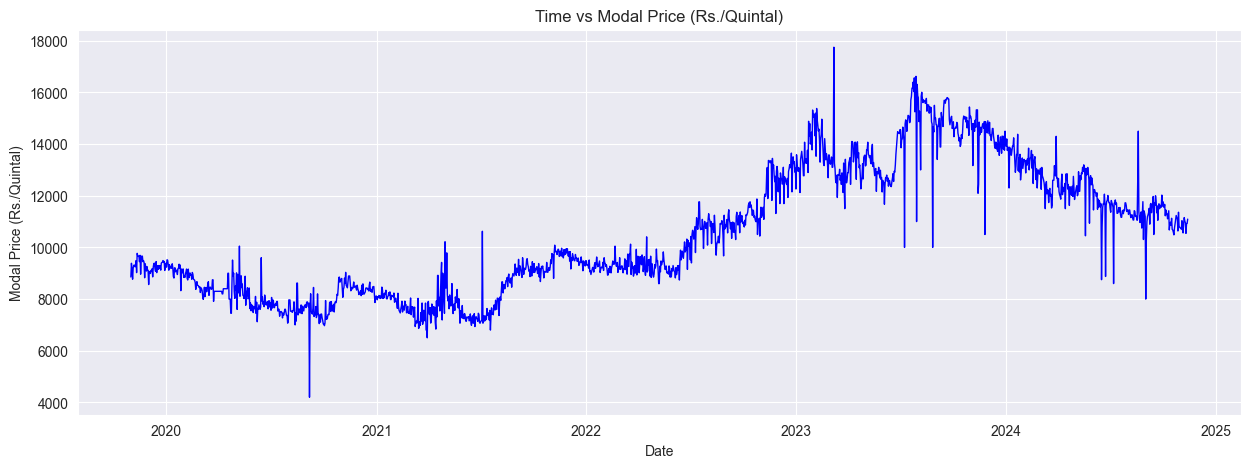

In [77]:
import matplotlib.pyplot as plt

# Plot 'Price Date' vs 'Modal Price (Rs./Quintal)'
plt.figure(figsize=(15, 5))
plt.plot(combined_df.index, combined_df['Modal Price (Rs./Quintal)'], color='blue', lw=1)
plt.title('Time vs Modal Price (Rs./Quintal)')
plt.xlabel('Date')
plt.ylabel('Modal Price (Rs./Quintal)')
plt.grid(True)
plt.show()


In [78]:
combined_df = create_features(combined_df)
combined_df

,Modal Price (Rs./Quintal),dayofweek,quarter,month,year,dayofyear,weekofyear,lag7,lag14,lag21,...,rolling_mean_28,rolling_median_28,rolling_std_28,ema7,ema14,moving_avg_7,moving_avg_14,max_28,min_28,range_28
Price Date,,,,,,,,,,,,,,,,,,,,,
2019-10-31,8854.900000,3,4,10,2019,304,44,NaN,NaN,NaN,...,8854.900000,8854.900000,NaN,8854.900000,8854.900000,8854.900000,8854.900000,8854.900000,8854.900000,0.000000
2019-11-01,9385.238095,4,4,11,2019,305,44,NaN,NaN,NaN,...,9120.069048,9120.069048,375.005663,8987.484524,8925.611746,9120.069048,9120.069048,9385.238095,8854.900000,530.338095
2019-11-02,9147.720930,5,4,11,2019,306,44,NaN,NaN,NaN,...,9129.286342,9147.720930,265.649204,9027.543625,8955.226304,9129.286342,9129.286342,9385.238095,8854.900000,530.338095
2019-11-03,8768.888889,6,4,11,2019,307,44,NaN,NaN,NaN,...,9039.186979,9001.310465,281.989209,8962.879941,8930.381315,9039.186979,9039.186979,9385.238095,8768.888889,616.349206
2019-11-04,9199.375000,0,4,11,2019,308,45,NaN,NaN,NaN,...,9071.224583,9147.720930,254.500444,9022.003706,8966.247140,9071.224583,9071.224583,9385.238095,8768.888889,616.349206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-09,10956.000000,5,4,11,2024,314,45,NaN,11096.297297,10592.647059,...,10902.858240,10922.392473,243.983819,10938.519833,10925.844588,10905.405433,10921.624743,11417.884615,10485.714286,932.170330
2024-11-10,10542.857143,6,4,11,2024,315,45,NaN,10635.166667,10485.714286,...,10871.607259,10884.620543,231.281611,10839.604160,10874.779596,10835.242168,10877.264539,11361.281250,10485.714286,875.566964
2024-11-11,10921.969697,0,4,11,2024,316,46,NaN,11361.281250,10748.242424,...,10880.427605,10916.710655,228.194651,10860.195544,10881.071609,10870.798279,10864.812568,11361.281250,10485.714286,875.566964


In [79]:
# Define the start and end date
start_date = '2024-11-02'
end_date = '2024-11-14'

# Filter rows between the two dates
date_filtered_df = combined_df.loc[start_date:end_date]

# Check how many rows (days) are in the filtered data
num_days = len(date_filtered_df)
print(f"Number of days between {start_date} and {end_date}: {num_days}")


Number of days between 2024-11-02 and 2024-11-14: 12


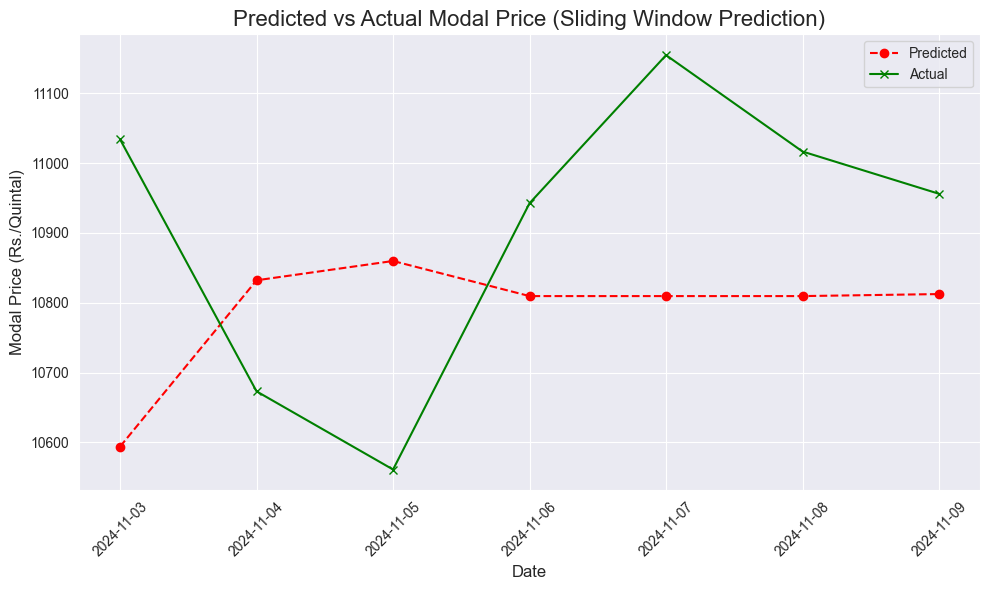

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta

# Define the start and end dates
start_date = '2024-11-03'
end_date = '2024-11-13'

# Define the sliding window size (1 week)
window_size = 7  # Days

# Initialize a list to store predictions and actual values
all_predictions = []
all_actuals = []

# Generate the date range for the prediction period
prediction_dates = pd.date_range(start=start_date, end=end_date, freq='D')

# We will move the window forward each week
current_start = pd.to_datetime(start_date)
current_end = current_start + timedelta(days=window_size - 1)

while current_end <= pd.to_datetime(end_date):
    # Extract the current window data
    current_window = combined_df.loc[current_start:current_end]

    # If the window has enough data, proceed with prediction
    if not current_window.empty:
        # Extract features (assuming features are the columns you need for prediction)
        X_current = current_window[feature_columns]

        # Make predictions for the current window
        y_pred_current = reg.predict(X_current)

        # Store predictions and actual values
        all_predictions.extend(y_pred_current)
        all_actuals.extend(current_window['Modal Price (Rs./Quintal)'].values)

    # Move the window forward by 1 week
    current_start = current_end + timedelta(days=1)
    current_end = current_start + timedelta(days=window_size - 1)

# Create a DataFrame for predictions and actuals for plotting
predicted_df = pd.DataFrame({'Date': prediction_dates[:len(all_predictions)], 'Predicted Modal Price': all_predictions})
actual_df = pd.DataFrame({'Date': prediction_dates[:len(all_actuals)], 'Actual Modal Price': all_actuals})

# Merge predicted and actual data on Date
result_df = pd.merge(predicted_df, actual_df, on='Date', how='left')

# Plot the predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(result_df['Date'], result_df['Predicted Modal Price'], label='Predicted', color='red', linestyle='--', marker='o')
plt.plot(result_df['Date'], result_df['Actual Modal Price'], label='Actual', color='green', linestyle='-', marker='x')
plt.title('Predicted vs Actual Modal Price (Sliding Window Prediction)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Modal Price (Rs./Quintal)', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [82]:
df_2024 = pd.read_csv("../VolumeData/spice_price_data_2024.csv")
df_2024 = df_2024[df_2024["Variety"]=="White"]

In [83]:
# Rename the column
df_2024 = df_2024.rename(columns={"Reported Date": "Price Date"})

# Verify the changes
print(df_2024.head())


        State Name  District Name           Market Name Variety      Group  \
1          Gujarat         Amreli                Rajula   White  Oil Seeds   
3          Gujarat     Banaskanth                 Deesa   White  Oil Seeds   
9          Gujarat      Bhavnagar  Mahuva(Station Road)   White  Oil Seeds   
17         Gujarat  Surendranagar           Dhragradhra   White  Oil Seeds   
23  Madhya Pradesh          Panna              Ajaygarh   White  Oil Seeds   

   Arrivals (Tonnes) Min Price (Rs./Quintal) Max Price (Rs./Quintal)  \
1               0.60                   12875                   12875   
3               3.30                   10805                   12505   
9               2.30                    6500                   13050   
17              1.40                    9500                   11005   
23              6.10                   10400                   10600   

   Modal Price (Rs./Quintal)   Price Date  
1                      12875  06 Nov 2024  
3         

In [84]:
# Convert 'Price Date' column to datetime, with invalid parsing entries turned into NaT
df_2024["Price Date"] = pd.to_datetime(df_2024["Price Date"], errors="coerce")

# Drop rows where 'Price Date' is NaT after conversion (if needed)
df_2024 = df_2024.dropna(subset=["Price Date"])

# Set 'Price Date' as the index
df_2024.set_index('Price Date', inplace=True)

# Verify the index dtype
index_dtype = df_2024.index.dtype
print(f"Datatype of the index: {index_dtype}")

# Check the resulting DataFrame
print(df_2024.head())


Datatype of the index: datetime64[ns]
                State Name  District Name           Market Name Variety  \
Price Date                                                                
2024-11-06         Gujarat         Amreli                Rajula   White   
2024-11-12         Gujarat     Banaskanth                 Deesa   White   
2024-11-07         Gujarat      Bhavnagar  Mahuva(Station Road)   White   
2024-11-06         Gujarat  Surendranagar           Dhragradhra   White   
2024-11-11  Madhya Pradesh          Panna              Ajaygarh   White   

                Group Arrivals (Tonnes) Min Price (Rs./Quintal)  \
Price Date                                                        
2024-11-06  Oil Seeds              0.60                   12875   
2024-11-12  Oil Seeds              3.30                   10805   
2024-11-07  Oil Seeds              2.30                    6500   
2024-11-06  Oil Seeds              1.40                    9500   
2024-11-11  Oil Seeds             

In [85]:
# Sort df_2024 by 'Price Date' (index)
df_2024 = df_2024.sort_index(ascending=True)
df_2024

,State Name,District Name,Market Name,Variety,Group,Arrivals (Tonnes),Min Price (Rs./Quintal),Max Price (Rs./Quintal),Modal Price (Rs./Quintal)
Price Date,,,,,,,,,
2024-11-02,Karnataka,Bidar,Basava Kalayana,White,Oil Seeds,2.00,7100,9700,8501
2024-11-02,Madhya Pradesh,Gwalior,Lashkar,White,Oil Seeds,3.00,12915,12915,12915
2024-11-03,Uttar Pradesh,Banda,Banda,White,Oil Seeds,40.00,10700,10950,10851
2024-11-03,Madhya Pradesh,Chhatarpur,LavKush Nagar(Laundi),White,Oil Seeds,17.20,9990,11000,11000
2024-11-03,Uttar Pradesh,Jalaun (Orai),Jalaun,White,Oil Seeds,16.00,10800,11500,11251
...,...,...,...,...,...,...,...,...,...
2024-11-13,Gujarat,Surendranagar,Dhragradhra,White,Oil Seeds,0.30,10570,10570,10570
2024-11-13,Gujarat,Amreli,Savarkundla,White,Oil Seeds,5.00,10500,13000,11750
2024-11-13,Gujarat,Amreli,Babra,White,Oil Seeds,0.80,10350,11750,11050


In [86]:
# Convert 'Modal Price (Rs./Quintal)' to float
df_2024['Modal Price (Rs./Quintal)'] = df_2024['Modal Price (Rs./Quintal)'].astype(float)

# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df_2024['Modal Price (Rs./Quintal)'].quantile(0.25)
Q3 = df_2024['Modal Price (Rs./Quintal)'].quantile(0.75)

# Calculate the IQR (Interquartile Range)
IQR = Q3 - Q1

# Define lower and upper bounds to identify outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the rows with outliers
df_2024 = df_2024[(df_2024['Modal Price (Rs./Quintal)'] >= lower_bound) & (df_2024['Modal Price (Rs./Quintal)'] <= upper_bound)]

# Verify the result
print(df_2024.head())


                State Name  District Name            Market Name Variety  \
Price Date                                                                 
2024-11-03   Uttar Pradesh          Banda                  Banda   White   
2024-11-03  Madhya Pradesh     Chhatarpur  LavKush Nagar(Laundi)   White   
2024-11-03   Uttar Pradesh  Jalaun (Orai)                 Jalaun   White   
2024-11-04       Karnataka       Kalburgi               Kalburgi   White   
2024-11-04   Uttar Pradesh  Jalaun (Orai)                   Orai   White   

                Group Arrivals (Tonnes) Min Price (Rs./Quintal)  \
Price Date                                                        
2024-11-03  Oil Seeds             40.00                   10700   
2024-11-03  Oil Seeds             17.20                    9990   
2024-11-03  Oil Seeds             16.00                   10800   
2024-11-04  Oil Seeds              2.00                    8000   
2024-11-04  Oil Seeds             16.00                   10000  

In [87]:
df_2024.columns

Index(['State Name', 'District Name', 'Market Name', 'Variety', 'Group',
       'Arrivals (Tonnes)', 'Min Price (Rs./Quintal)',
       'Max Price (Rs./Quintal)', 'Modal Price (Rs./Quintal)'],
      dtype='object')

In [88]:
# Ensure 'Modal Price (Rs./Quintal)' is numeric and coercing errors to NaN
df_2024['Modal Price (Rs./Quintal)'] = pd.to_numeric(df_2024['Modal Price (Rs./Quintal)'], errors='coerce')

# Drop rows with NaN in 'Modal Price (Rs./Quintal)'
df_2024 = df_2024.dropna(subset=['Modal Price (Rs./Quintal)'])

# Now, resample and calculate the mean for only 'Modal Price (Rs./Quintal)'
df_2024_mean = df_2024[['Modal Price (Rs./Quintal)']].resample('D').mean()

# Verify the result
print(df_2024_mean.head())


            Modal Price (Rs./Quintal)
Price Date                           
2024-11-03               11034.000000
2024-11-04               10479.166667
2024-11-05               10561.111111
2024-11-06               10964.321429
2024-11-07               10952.608696


/var/folders/nh/b1_7lrqd3230f7mwnl4b2r3c0000gn/T/ipykernel_78596/733941035.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2024['Modal Price (Rs./Quintal)'] = pd.to_numeric(df_2024['Modal Price (Rs./Quintal)'], errors='coerce')


In [89]:
df_2024_mean = create_features(df_2024_mean)
df_2024_mean

,Modal Price (Rs./Quintal),dayofweek,quarter,month,year,dayofyear,weekofyear,lag7,lag14,lag21,...,rolling_mean_28,rolling_median_28,rolling_std_28,ema7,ema14,moving_avg_7,moving_avg_14,max_28,min_28,range_28
Price Date,,,,,,,,,,,,,,,,,,,,,
2024-11-03,11034.000000,6,4,11,2024,308,44,10635.166667,10485.714286,10933.333333,...,11034.000000,11034.000000,NaN,11034.000000,11034.000000,11034.000000,11034.000000,11034.0,11034.000000,0.000000
2024-11-04,10479.166667,0,4,11,2024,309,45,11361.281250,10748.242424,10973.571429,...,10756.583333,10756.583333,392.326412,10895.291667,10960.022222,10756.583333,10756.583333,11034.0,10479.166667,554.833333
2024-11-05,10561.111111,1,4,11,2024,310,45,10820.263158,10911.451613,10857.789474,...,10691.425926,10561.111111,299.493690,10811.746528,10906.834074,10691.425926,10691.425926,11034.0,10479.166667,554.833333
2024-11-06,10964.321429,2,4,11,2024,311,45,10780.000000,11042.821429,11127.741935,...,10759.649802,10762.716270,280.027919,10849.890253,10914.499055,10759.649802,10759.649802,11034.0,10479.166667,554.833333
2024-11-07,10952.608696,3,4,11,2024,312,45,NaN,11235.054054,10701.137931,...,10798.241580,10952.608696,257.406981,10875.569864,10919.580340,10798.241580,10798.241580,11034.0,10479.166667,554.833333
2024-11-08,10864.142857,4,4,11,2024,313,45,NaN,11163.900000,10674.894737,...,10809.225127,10908.375776,231.798431,10872.713112,10912.188676,10809.225127,10809.225127,11034.0,10479.166667,554.833333
2024-11-09,10956.000000,5,4,11,2024,314,45,NaN,11096.297297,10592.647059,...,10830.192966,10952.608696,218.753238,10893.534834,10918.030186,10830.192966,10830.192966,11034.0,10479.166667,554.833333
2024-11-10,10542.857143,6,4,11,2024,315,45,NaN,10635.166667,10485.714286,...,10794.275988,10908.375776,226.576860,10805.865411,10868.007113,10760.029700,10794.275988,11034.0,10479.166667,554.833333
2024-11-11,10857.031250,0,4,11,2024,316,46,NaN,11361.281250,10748.242424,...,10801.248795,10864.142857,212.973049,10818.656871,10866.543665,10814.010355,10801.248795,11034.0,10479.166667,554.833333


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

plt.plot(future_w_features['pred'], color=color_pal[4], marker='o', markersize=3, linewidth=1, label='Predictions')

plt.plot(df_2024_mean['Modal Price (Rs./Quintal)'], color=color_pal[0], marker='o', markersize=3, linewidth=1, label='Actual Prices')

plt.title('Future Predictions vs Actual Prices')
plt.xlabel('Date')
plt.ylabel('Price (Rs./Quintal)')
plt.legend()
plt.show()


In [94]:
#Create future dataframe
future = pd.date_range('2024-10-31', '2024-11-6', freq='1d')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)

In [95]:
future_w_features = df_and_future.query('isFuture').copy()

In [96]:
future_w_features2 = future_w_features.drop(columns=[TARGET, 'isFuture'])
future_w_features['pred'] = reg.predict(future_w_features2)

<Axes: title={'center': 'Future Predictions'}>

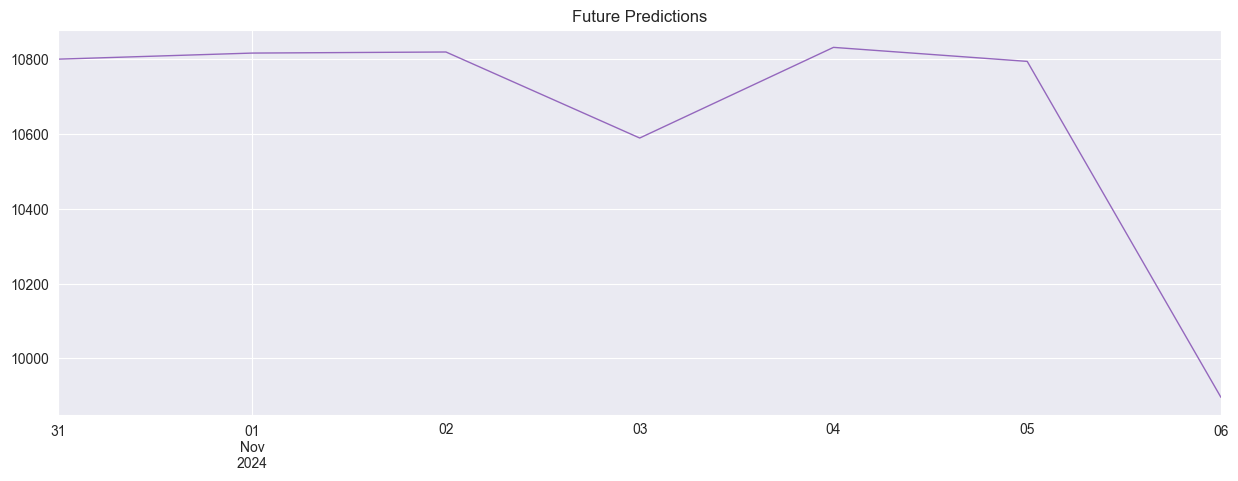

In [97]:
future_w_features['pred'].plot(figsize=(15, 5), color=color_pal[4], ms=1, lw=1, title='Future Predictions')